In [1]:
import qiskit

In [2]:
pip install git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src

  Cloning https://github.com/qiskit-community/qiskit-textbook.git to c:\users\anirudh\appdata\local\temp\pip-req-build-r1a5rl4a
Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: inflection>=0.3.1 in c:\users\anirudh\anaconda3\lib\site-packages (from quandl->qiskit-aqua==0.8.1->qiskit->qiskit-textbook==0.1.0) (0.5.1)



  Created wheel for qiskit-textbook: filename=qiskit_textbook-0.1.0-py3-none-any.whl size=17069 sha256=6b9c97c096ae8e8139650747cf52e38385cae56df8d565278d59f4822086dc85
  Stored in directory: C:\Users\ANIRUDH\AppData\Local\Temp\pip-ephem-wheel-cache-l_0mm5su\wheels\80\c4\dd\b7ea1ee2a7247e8997db78bc777bbe22e61ab1e5ed1c4b46e1
Successfully built qiskit-textbook


In [3]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.visualization import SchedStyle
# Loading your IBM Q account(s)
provider = IBMQ.load_account()
IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')

C:\Users\ANIRUDH\anaconda3\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [4]:
backend_config = backend.configuration()
backend_defaults = backend.defaults()
backend.configuration().parametric_pulses = []  # Will allow us to send a larger waveform for our experiments
style = SchedStyle(figsize=(3, 2), title_font_size=10, axis_font_size=8) # style for displaying the pulse sequence

In [5]:
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter

# samples need to be multiples of 16 to accommodate the hardware limitations
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

# process the reflective measurement results
# in a reflective measurement the data is encoded in the phase of the output signal
def process_reflective_measurement(freqs,values):
    phase_grad = np.gradient(savgol_filter(np.unwrap(np.angle(values)),3,2),freqs)
    return (phase_grad-min(phase_grad))/(max(phase_grad)-min(phase_grad)) - 1

# lorentzian function
def lorentzian(f, f0, k, a, offs):
    return -a*k/(2*np.pi)/((k/2)**2+(f-f0)**2)+offs

#fit_lorentzian takes two arrays that contain the frequencies and experimental output values of each frequency respectively. 
#returns the lorentzian parameters that best fits this output of the experiment.
#popt are the fit parameters and pcov is the covariance matrix for the fit
def fit_lorentzian(freqs,values):
    p0=[freqs[np.argmin(values)],(freqs[-1]-freqs[0])/2,min(values),0]
    bounds=([freqs[0],0,-np.inf,-np.inf],[freqs[-1],freqs[-1]-freqs[0],np.inf,np.inf])
    popt,pcov=curve_fit(lorentzian, freqs, values, p0=p0, bounds=bounds)
    return popt,pcov

# exponential function
def exponential(t,tau,a,offset):
    return a*np.exp(-t/tau)+offset

# fit an exponential function
def fit_exponential(ts,values):
    p0=[np.average(ts),1,0]
    return curve_fit(exponential, ts, values,p0=p0)

In [6]:
from qiskit import pulse            # This is where we access all of our Pulse features!
from qiskit.pulse import Play, Acquire
from qiskit.pulse import pulse_lib
import numpy as np

dt=backend_config.dt   # hardware resolution

qubit=0   # qubit used in our experiment

readout_time = 4e-6
readout_sigma = 10e-9 

# low power drive for the resonator for dispersive readout
# We use a square pulse with a Guassian rise and fall time
readout_drive_low_power=pulse_lib.GaussianSquare(duration = get_closest_multiple_of_16(readout_time//dt),
                             amp = .3,
                             sigma = get_closest_multiple_of_16(readout_sigma//dt),
                             width = get_closest_multiple_of_16((readout_time-8*readout_sigma)//dt),
                             name = 'low power readout tone')

meas_chan = pulse.MeasureChannel(qubit) # resonator channel
acq_chan = pulse.AcquireChannel(qubit)  # readout signal acquisition channel

# readout output signal acquisition setup
acquisition_time = readout_time   # We want to acquire the readout signal for the full duration of the readout

<ipython-input-6-058d785ce463>:3: DeprecationWarning: the pulse_lib module is deprecated, pulse_lib is renamed to library
  from qiskit.pulse import pulse_lib


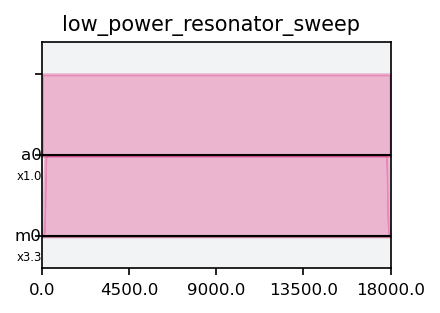

In [7]:
# build the pulse sequence for low power resonator spectroscopy
with pulse.build(name='low_power_resonator_sweep') as pulse_low_power:
    #drive the resonator with low power
    pulse.play(readout_drive_low_power, meas_chan) 
    #acquire the readout signal
    pulse.acquire(duration = get_closest_multiple_of_16(acquisition_time//dt),
                    qubit_or_channel = acq_chan,
                    register = pulse.MemorySlot(0))
    
pulse_low_power.draw(style=style)

In [8]:
center_freq = backend_defaults.meas_freq_est[qubit]  # an estimate for the resonator frequency
freq_span = 0.3e6 # resonator scan span. The span should be larger than the resonator linewidth kappa

frequencies_range = np.linspace(center_freq-freq_span/2,center_freq+freq_span/2,41)
# list of resonator frequencies for the experiment
schedule_frequencies = [{meas_chan: freq} for freq in frequencies_range] 

In [9]:
from qiskit import assemble
from qiskit.tools.monitor import job_monitor

num_shots_per_frequency = 2*1024 
frequency_sweep_low_power = assemble(pulse_low_power,
                                   backend=backend, 
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_frequency,
                                   schedule_los=schedule_frequencies)

job_low_power = backend.run(frequency_sweep_low_power)
job_monitor(job_low_power)

low_power_sweep_results = job_low_power.result(timeout=120)

Job Status: job has successfully run


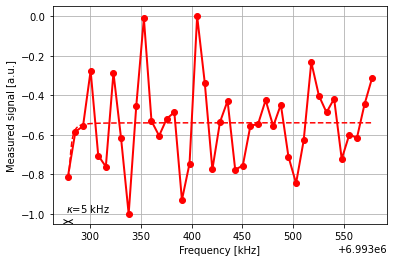

In [10]:
import matplotlib.pyplot as plt

low_power_sweep_values = []
for i in range(len(low_power_sweep_results.results)):
    res_low_power = low_power_sweep_results.get_memory(i)
    low_power_sweep_values.append(res_low_power[qubit])

low_power_sweep_values = process_reflective_measurement(frequencies_range,low_power_sweep_values)

plt.plot(frequencies_range/1e3, low_power_sweep_values,'-o', color='red', lw=2)

popt_low_power,_=fit_lorentzian(frequencies_range,low_power_sweep_values)

popt_low_power,_=fit_lorentzian(frequencies_range,low_power_sweep_values)
f0, kappa, a, offset = popt_low_power

fs=np.linspace(frequencies_range[0],frequencies_range[-1],1000)
plt.plot(fs/1e3, lorentzian(fs,*popt_low_power), color='red', ls='--')
plt.annotate("", xy=((f0-kappa/2)/1e3, offset-1/2), xytext=((f0+kappa/2)/1e3, offset-1/2), arrowprops=dict(arrowstyle="<->", color='black'))
plt.annotate("$\kappa$={:d} kHz".format(int(kappa/1e3)), xy=((f0-kappa/2)/1e3, offset-.45), color='black')

plt.grid()
plt.xlabel("Frequency [kHz]")
plt.ylabel("Measured signal [a.u.]")
plt.show()

In [11]:
readout_drive_high_power=pulse_lib.GaussianSquare(duration = get_closest_multiple_of_16(readout_time//dt),
                             amp = 1, # High drive amplitude
                             sigma = get_closest_multiple_of_16(readout_sigma//dt),
                             width = get_closest_multiple_of_16((readout_time-8*readout_sigma)//dt),
                             name = 'high power readout tone')

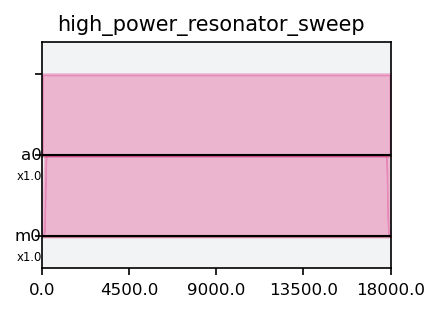

In [12]:
# build the pulse sequence for high power resonator spectroscopy
with pulse.build(name='high_power_resonator_sweep') as pulse_high_power:
    #drive the resonator with high power
    pulse.play(readout_drive_high_power, meas_chan)
    #acquire the readout signal
    pulse.acquire(duration = get_closest_multiple_of_16(acquisition_time//dt),
                    qubit_or_channel = acq_chan,
                    register = pulse.MemorySlot(0))
    
pulse_high_power.draw(style=style)

In [13]:
frequency_sweep_high_power = assemble(pulse_high_power,
                                   backend=backend, 
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_frequency,
                                   schedule_los=schedule_frequencies)

job_high_power = backend.run(frequency_sweep_high_power)
job_monitor(job_high_power)

high_power_sweep_results = job_high_power.result(timeout=120)

Job Status: job has successfully run


In [14]:
high_power_sweep_values = []
for i in range(len(high_power_sweep_results.results)):
    res_high_power = high_power_sweep_results.get_memory(i)
    high_power_sweep_values.append(res_high_power[qubit])

high_power_sweep_values = process_reflective_measurement(frequencies_range,high_power_sweep_values)

popt_high_power,_=fit_lorentzian(frequencies_range,high_power_sweep_values)

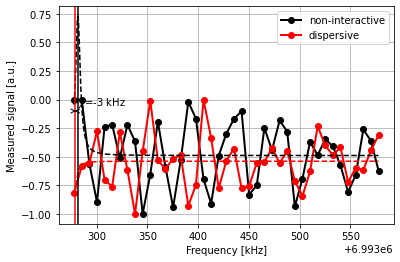

chi=-3.3 kHz
g=nan MHz


<ipython-input-15-4e795e3a0afe>:23: RuntimeWarning: invalid value encountered in sqrt
  print(r'g={:.1f} MHz'.format(np.sqrt(chi*Delta)/1e6))


In [15]:
plt.plot(frequencies_range/1e3, high_power_sweep_values, '-o', color='black', lw=2, label='non-interactive')
plt.plot(frequencies_range/1e3, low_power_sweep_values,'-o', color='red', lw=2, label='dispersive')

fs=np.linspace(frequencies_range[0],frequencies_range[-1],1000)
plt.plot(fs/1e3, lorentzian(fs,*popt_high_power), color='black', ls='--')
plt.plot(fs/1e3, lorentzian(fs,*popt_low_power), color='red', ls='--')

plt.axvline(x=popt_low_power[0]/1e3, color='red')
plt.axvline(x=popt_high_power[0]/1e3, color='black')

chi=popt_low_power[0]-popt_high_power[0]
plt.annotate("", xy=(popt_low_power[0]/1e3, -.1), xytext=(popt_high_power[0]/1e3, -.1), arrowprops=dict(arrowstyle="<->", color='black'))
plt.annotate("$\chi$={:d} kHz".format(int(chi/1e3)), xy=(popt_high_power[0]/1e3, -.05), color='black')

plt.grid()
plt.xlabel("Frequency [kHz]")
plt.ylabel("Measured signal [a.u.]")
plt.legend()
plt.show()

print(r'chi={:.1f} kHz'.format((popt_low_power[0]-popt_high_power[0])/1e3))
Delta=abs(backend_defaults.meas_freq_est[qubit] - backend_defaults.qubit_freq_est[qubit])
print(r'g={:.1f} MHz'.format(np.sqrt(chi*Delta)/1e6))

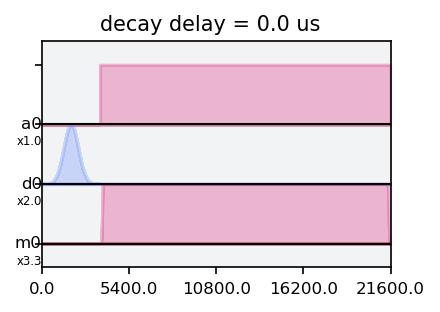

In [16]:
drive_sigma = 100e-9
drive_duration = 8*drive_sigma

# qubit micrwave drive
# We use a Gaussian pulse to excite our qubit
qubit_drive = pulse_lib.gaussian(duration = get_closest_multiple_of_16(drive_duration//dt),
                             amp = .5,
                             sigma = get_closest_multiple_of_16(drive_sigma//dt),
                             name = 'qubit tone')

drive_chan = pulse.DriveChannel(qubit) # qubit drive channel

# We drive our qubit, wait for some time (time delay), and then measure the qubit
# Using these measurements we can create a plot of qubit population vs. time delay
delay_times=np.linspace(0,600e-6,61) #measurement time delays
qubit_decay_pulses = []
for delay in delay_times:
    
    with pulse.build(name=f"decay delay = {delay * 1e6} us") as temp_decay_pulse:
        #drive the qubit
        pulse.play(qubit_drive, drive_chan)
        #meanwhile do nothing with the resonator
        pulse.delay(get_closest_multiple_of_16(drive_duration//dt), meas_chan)
        #wait for the duration of the time delay before measuring the qubit
        pulse.delay(int(delay//dt), meas_chan)
        
        #sequence for measuring the qubit
        with pulse.build() as temp_sched:
            #drive the resonator with low power
            pulse.play(readout_drive_low_power, meas_chan)
            #acquire the readout signal
            pulse.acquire(duration = get_closest_multiple_of_16(acquisition_time//dt),
                            qubit_or_channel = acq_chan,
                            register = pulse.MemorySlot(0))
        
        #call the measuring sequence
        pulse.call(temp_sched)
        
    qubit_decay_pulses.append(temp_decay_pulse)

qubit_decay_pulses[0].draw(style=style)

In [17]:
# setting the readout frequency to the resontor frequecy in the dispersive limit measured earlier
# setting the qubit freqency to the default value
los = [{meas_chan: f0, drive_chan: backend_defaults.qubit_freq_est[qubit]}] # pulse frequencies for each channel

num_shots = 4*1024  # increasing this number will make your output more accurate,
                    # but it will slow down the experiment

qubit_decay_experiment = assemble(qubit_decay_pulses,
                         backend=backend, 
                         meas_level=1,
                         meas_return='avg',
                         shots=num_shots,
                         schedule_los= los * len(qubit_decay_pulses))

job_qubit_decay = backend.run(qubit_decay_experiment)
job_monitor(job_qubit_decay)

Job Status: job has successfully run


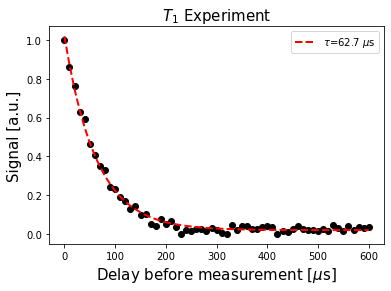

gamma=  15.95 kHz


In [18]:
qubit_decay_results = job_qubit_decay.result(timeout=120)

qubit_decay_values = []
for i in range(len(delay_times)):
    qubit_decay_values.append(qubit_decay_results.get_memory(i)[qubit])
qubit_decay_values = np.abs(qubit_decay_values)
qubit_decay_values = (qubit_decay_values-min(qubit_decay_values))
qubit_decay_values/=max(qubit_decay_values)

decay_popt,_=fit_exponential(delay_times, qubit_decay_values)
tau=decay_popt[0]
g=1/tau

plt.scatter(delay_times*1e6, qubit_decay_values, color='black') 
plt.plot(delay_times*1e6,exponential(delay_times,*decay_popt),'--',lw=2,color='red',label=r'$\tau$={:.1f} $\mu$s'.format(tau*1e6))
plt.title("$T_1$ Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)
plt.legend()
plt.show()

print(r'gamma=  {:.2f} kHz'.format(g/1e3))